In [1]:
from tqdm import tqdm
from requests import request
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

### Downloading residual load data from SMARD API
Before the residual load data can be gathered from the API, timestamps have to be downloaded first. This is caused by the limitation of the data count by request from the SMARD API. The timestamps shows in which intervals, the data can be gathered. Code 4359 in the request represents residual load.

In [2]:
res = request("GET", 'https://www.smard.de/app/chart_data/4359/DE/index_hour.json')
timestamps = res.json()["timestamps"]

In [3]:
time_series = []
for timestamp in tqdm(timestamps):
    res = request("GET", "https://www.smard.de/app/chart_data/4359/DE/4359_DE_hour_" +str(timestamp)+".json")
    body = res.json()["series"]
    time_series += body

100%|██████████| 467/467 [01:21<00:00,  5.75it/s]


### Transforming the residual laod dataset into a dataframe and cleaning up missing values and wrong columns

In [4]:
residual_load_dataset = pd.DataFrame(time_series)
residual_load_dataset.index = [pd.Timestamp(x, unit='ms') for x in residual_load_dataset.iloc[:, 0]]
residual_load_dataset = residual_load_dataset.drop(columns=0)
residual_load_dataset = residual_load_dataset.dropna()
residual_load_dataset.columns = ["Residual Load"]
residual_load_dataset.head()

,Residual Load
2014-12-31 23:00:00,35955.75
2015-01-01 00:00:00,34641.00
2015-01-01 01:00:00,32909.25
2015-01-01 02:00:00,31548.00
2015-01-01 03:00:00,30773.50


### Plot history and distribution of the residual load data

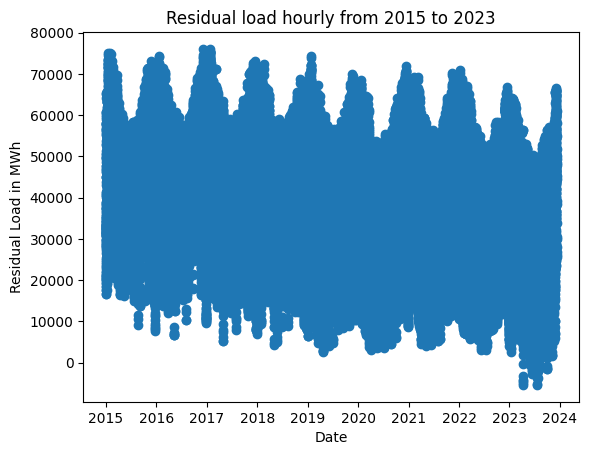

In [5]:
plt.scatter(residual_load_dataset.index, residual_load_dataset["Residual Load"])
plt.title("Residual load hourly from 2015 to 2023")
plt.xlabel("Date")
plt.ylabel("Residual Load in MWh")
plt.show()

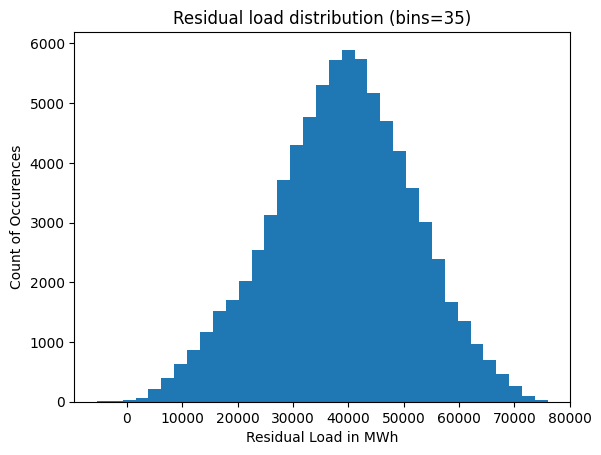

In [6]:
plt.hist(residual_load_dataset["Residual Load"], bins=35)
plt.title("Residual load distribution (bins=35)")
plt.xlabel("Residual Load in MWh")
plt.ylabel("Count of Occurences")
plt.show()

### Function for transforming data from DWD into a Dataframe
Using the description to rename columns into a human understandable format. Transforming the timepoints to pandas specific data type.

In [7]:
def extract_dwd_data(residual_load_dataset, station_id):
    
    station_data = [x for x in listdir("dwd_data") if station_id in x]
    
    wind_data = pd.read_csv("dwd_data/" + [x for x in station_data if "produkt_f" in x][0], sep=";").iloc[-80000:]
    solar_data = pd.read_csv("dwd_data/" + [x for x in station_data if "produkt_sd" in x][0], sep=";").iloc[-80000:]
    temperature_data = pd.read_csv("dwd_data/" + [x for x in station_data if "produkt_tu" in x][0], sep=";").iloc[-80000:]
    precipitation_data = pd.read_csv("dwd_data/" + [x for x in station_data if "produkt_rr" in x][0], sep=";").iloc[-80000:]
    
    wind_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in wind_data["MESS_DATUM"]]
    wind_data = wind_data.drop(columns="MESS_DATUM")
    wind_data = wind_data.rename(columns={"  FF": "Wind Velocity for Station " + station_id})
    solar_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in solar_data["MESS_DATUM"]]
    solar_data = solar_data.drop(columns="MESS_DATUM")
    solar_data = solar_data.rename(columns={"SD_SO": "Sun Duration for Station " + station_id})
    temperature_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in temperature_data["MESS_DATUM"]]
    temperature_data = temperature_data.drop(columns="MESS_DATUM")
    temperature_data = temperature_data.rename(columns={"TT_TU": "Air Temperature for Station " + station_id})
    precipitation_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in precipitation_data["MESS_DATUM"]]
    precipitation_data = precipitation_data.drop(columns="MESS_DATUM")
    precipitation_data = precipitation_data.rename(columns={"  R1": "Precipitation Amount for Station " + station_id})

    residual_load_dataset = pd.concat([residual_load_dataset, wind_data["Wind Velocity for Station " + station_id], solar_data["Sun Duration for Station " + station_id], temperature_data["Air Temperature for Station " + station_id], precipitation_data["Precipitation Amount for Station " + station_id]], axis=1)
    
    return residual_load_dataset

### Apply the extract function to the downloaded data

In [8]:
for i in ["02014", "03987", "03379", "04928"]:
    residual_load_dataset = extract_dwd_data(residual_load_dataset, i)

### Drop missing values

In [9]:
residual_load_dataset = residual_load_dataset.dropna()

### Plot correlation of influencers and the target variable

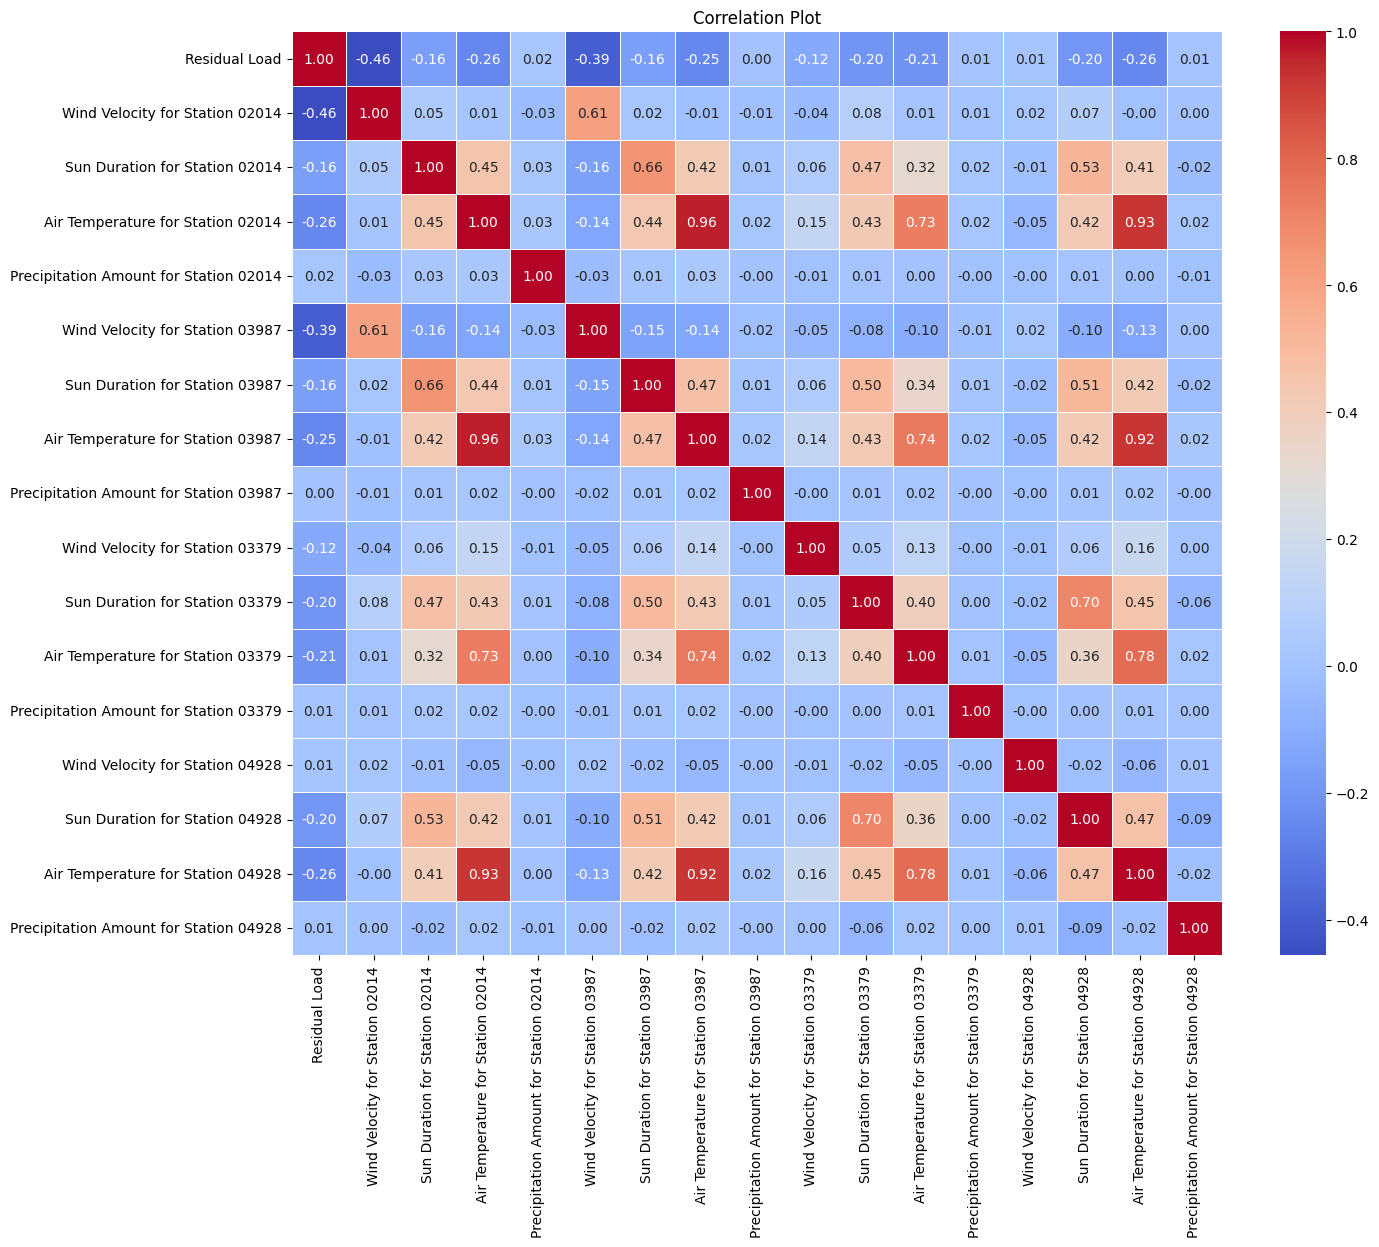

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns


numeric_columns = residual_load_dataset.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Plot')
plt.show()

### Extracting seasonal information of month, quarter and year from the timestamps

In [11]:
residual_load_dataset["Month"] = [x.month for x in list(residual_load_dataset.index)]
residual_load_dataset["Quarter"] = [x.quarter for x in list(residual_load_dataset.index)]
residual_load_dataset["Year"] = [x.year for x in list(residual_load_dataset.index)]

### Rearange the data set for better usability

In [12]:
cols = residual_load_dataset.columns.tolist()
cols = cols[1:] + [cols[0]]
residual_load_dataset = residual_load_dataset[cols]
residual_load_dataset.head()

,Wind Velocity for Station 02014,Sun Duration for Station 02014,Air Temperature for Station 02014,Precipitation Amount for Station 02014,Wind Velocity for Station 03987,Sun Duration for Station 03987,Air Temperature for Station 03987,Precipitation Amount for Station 03987,Wind Velocity for Station 03379,Sun Duration for Station 03379,Air Temperature for Station 03379,Precipitation Amount for Station 03379,Wind Velocity for Station 04928,Sun Duration for Station 04928,Air Temperature for Station 04928,Precipitation Amount for Station 04928,Month,Quarter,Year,Residual Load
2015-01-01 03:00:00,3.7,0.0,2.8,0.0,6.0,0.0,3.5,0.0,-999.0,0.0,-3.2,0.0,1.0,0.0,0.5,0.0,1,1,2015,30773.50
2015-01-01 04:00:00,4.2,0.0,2.5,0.0,6.7,0.0,2.6,0.0,-999.0,0.0,-3.3,0.0,1.8,0.0,0.4,0.0,1,1,2015,30040.75
2015-01-01 05:00:00,3.0,0.0,2.0,0.0,5.6,0.0,2.2,0.0,-999.0,0.0,-4.3,0.0,3.2,0.0,0.5,0.0,1,1,2015,28161.50
2015-01-01 06:00:00,3.8,0.0,1.9,0.0,5.7,0.0,2.1,0.0,-999.0,0.0,-4.5,0.0,2.1,0.0,0.6,0.0,1,1,2015,27767.25
2015-01-01 07:00:00,3.1,0.0,1.4,0.0,5.5,0.0,2.7,0.0,-999.0,0.0,-3.9,0.0,0.2,0.0,0.6,0.0,1,1,2015,28531.25


### Plot distribution of influencing values

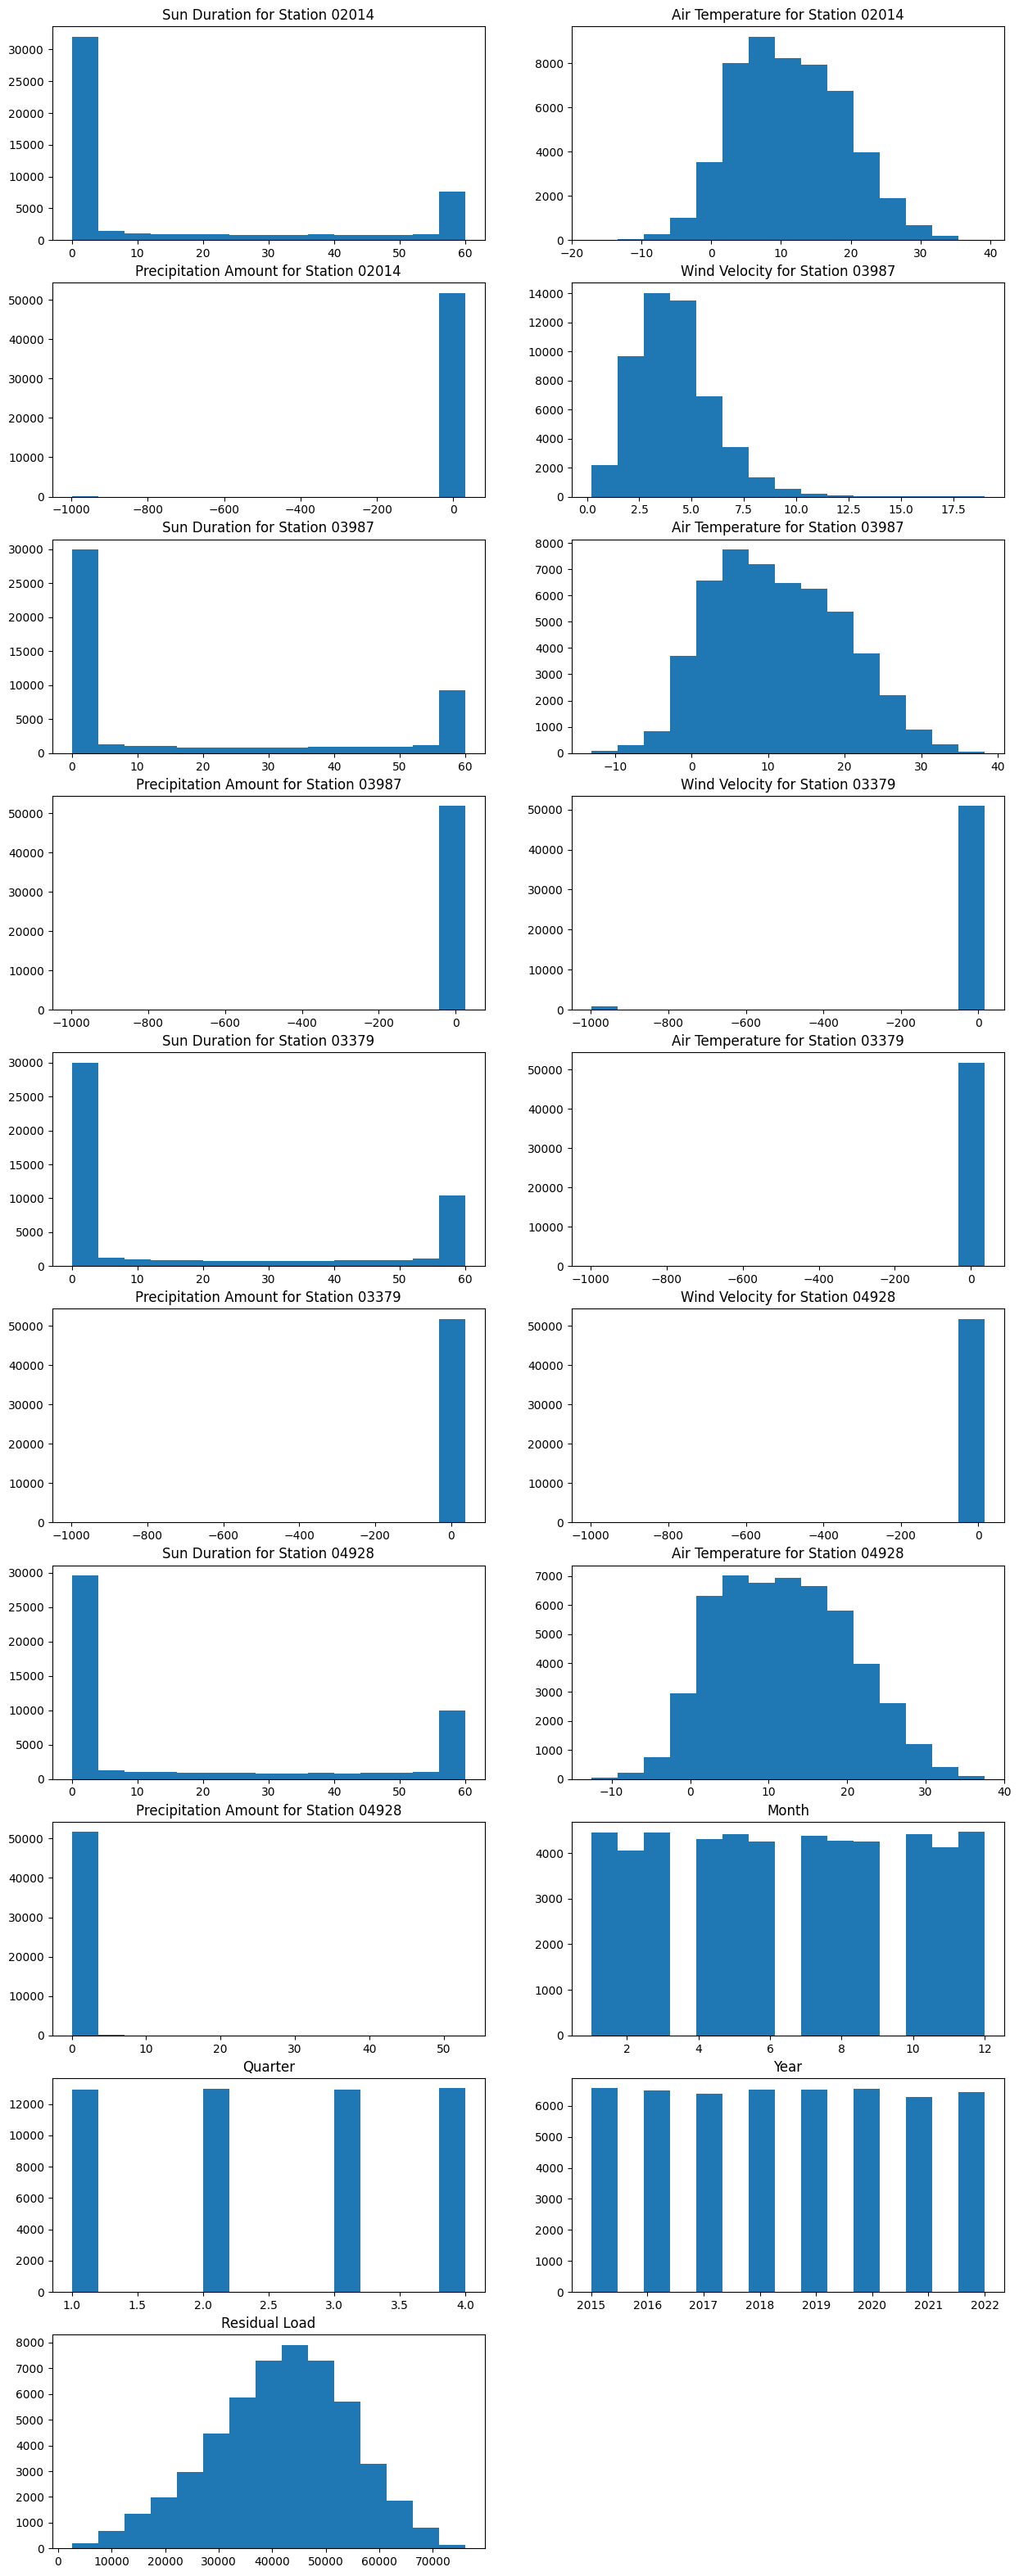

In [13]:
from tqdm import tqdm

# create all combinations of considered columns
#combinations = itertools.combinations(features, 2)

# create a figure and specify its size
fig = plt.figure(figsize=(15,40))

# go through all combinations and create one plot for each
figure_index = 1
for column in residual_load_dataset.columns[1:]:
    # add a sub plot to the figure
    axs = fig.add_subplot(10,2,figure_index)
    axs.hist(residual_load_dataset[column], bins=15)
    axs.set_title(column)
    # increase the figure index (otherwise all plots are drawn in the first subplot)
    figure_index+=1


# show the plot
plt.show()

### Save to .csv file for no further downloading data

In [14]:
residual_load_dataset.to_csv("Residual Load Dataset.csv")